# Overview
Use this notebook to convert an OCT image you have to an H&E image in order to evaluate how the code works.

To get started,
[open this notebook in colab](https://colab.research.google.com/github/WinetraubLab/OCT2Hist-UseModel/blob/main/ConvertOCTImagesToHistology.ipynb) and run.

## Notebook's Inputs:

In [1]:
# Path to an OCT image to convert
oct_input_image_path = "/content/drive/Shareddrives/Yolab - Current Projects/Paulo de Luna/Pix2Pix/test_results/oct2_he_pix2pix/test_latest/images/LG-44-Slide04_Section02_yp0_patch01_real_real_A.png"

# Path to a folder in drive to output the converted H&E images, leave blank if
# you don't want to save H&E image to drive.
histology_output_image_folder = ""

# Set Up Environment
Clone repository and install dependencies:

In [2]:
import os

# Clone repository
!git clone --recurse-submodules https://github.com/WinetraubLab/OCT2Hist-UseModel

base_folder = "/content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix"

# Install dependencies
!pip install -r {base_folder}/requirements.txt

# Clean up this window once install is complete
from IPython.display import clear_output
clear_output()

Copy model weights from google drive

In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

# This is the folder that the pre-trained model is in
model_folder = "/content/drive/Shareddrives/Yolab - Current Projects/_Datasets/2020-11-10 10x Model (Paper V2)"

# Copy model to this folder over
!mkdir {base_folder}/checkpoints
!mkdir {base_folder}/checkpoints/pix2pix/
!cp "{model_folder}/latest_net_G.pth" {base_folder}/checkpoints/pix2pix/
!cp "{model_folder}/latest_net_D.pth" {base_folder}/checkpoints/pix2pix/

Mounted at /content/drive/


# Preprocess
Mask images, crop and convert to the right size

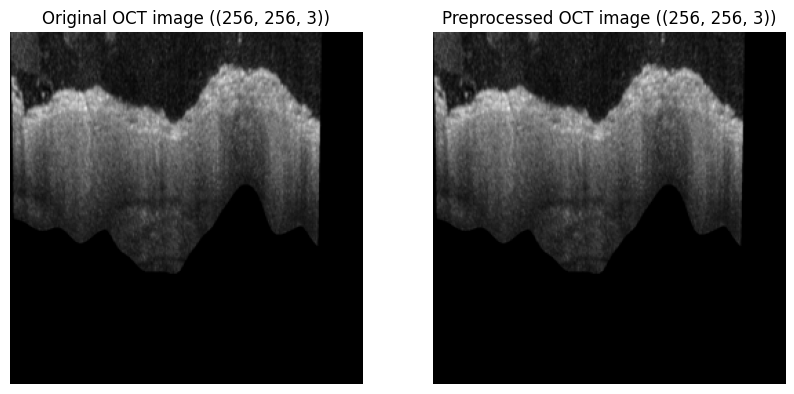

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Load OCT image
oct_image_orig = cv2.imread(oct_input_image_path)
oct_image_orig = cv2.cvtColor(oct_image_orig, cv2.COLOR_BGR2RGB)

# Show Images to user
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
oct_image_orig_shape = oct_image_orig.shape
axes[0].imshow(oct_image_orig)
axes[0].axis("off")
axes[0].set_title(f"Original OCT image ({oct_image_orig_shape})")



In [ ]:
import cv2
import matplotlib.pyplot as plt

def showImgByPath(path):
  """Show the image for filepath <path>"""
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.figure()
  plt.imshow(image)

def readImgByPath(path):
  """Return the image for filepath <path> """
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

def showImg(image):
  """Show the image, which content is in image."""
  plt.figure()
  plt.imshow(image)

def showTwoImgs(img1, img2):
  """Show both images, side by side."""
  plt.subplot(1,2,1);
  plt.imshow(img1);
  plt.subplot(1,2,2);
  plt.imshow(img2);

def get_first_zero_and_next_non_zero_idx(arr):
  """
  For an input array <arr>, returns the first zero index i_0, and the next non-zero index i_1 > i_0.
  """
  first_zero = (arr==0).argmax()
  tmp = np.copy(arr);
  tmp[:first_zero] = 0
  next_non_zero = (tmp>0).argmax(axis=0)
  return first_zero, next_non_zero

In [ ]:
#a new image from
path_new_image = oct_input_image_path;
showImgByPath(path_new_image);
img = readImgByPath(path_new_image);

In [ ]:
# Apply a gaussian filter to smooth everything, it will help make the thresholding smoother
import numpy as np;
import cv2;

sigma = 20;
#the default filter size in Matlab
filter_size = int(2*np.ceil(2*sigma)+1);
filt_img = cv2.GaussianBlur(img,(filter_size,filter_size),sigma)
showImg(filt_img)

In [ ]:
# Average over x axis (rows) to get one value for each depth
m_mean = np.nanmean(filt_img,axis=1);
print(m_mean.shape)
print(m_mean)

In [ ]:
# Then we figure out what is the "brightest" row by taking percentile:
m_mean_max = np.percentile(m_mean, 99, axis=0)
print(m_mean_max.shape)
print(m_mean_max)

In [ ]:
# Then we figure out what is the noise floor of the device, by examining the bottom 50 rows of OCT image
m_mean_min = np.mean(m_mean[-50:]);
print(m_mean_min.shape)
print(m_mean_min)

In [ ]:
# Finally we define a threshold for OCT intensity, anything below that will be blacked out
minSignal = 0.28 * (m_mean_max - m_mean_min) + m_mean_min;

In [ ]:
filt_img[filt_img<minSignal] = 0;
showImg(filt_img)

In [ ]:
#Assuming the top and bottom 10% of the mask should be black:
height = filt_img.shape[0]
p = 0.1
filt_img[0:int(p*height),:]=0
filt_img[int((1-p)*height):,:]=0
showImg(filt_img)

In [ ]:
# get mean over x axis (rows) to get one value for each depth, for new thresholded image.
m_mean = np.nanmean(filt_img,axis=1);

#assume there's a non-black area around the middle of the image, surrounded by black area.
#Find the first black line, and the next non black line.
m_mean_arr = np.copy(m_mean[:,0])
print("rows indicating black segments in image:")
first_zero, next_non_zero = get_first_zero_and_next_non_zero_idx(m_mean_arr);
print(first_zero, next_non_zero)

#Do the same to the vertically flipped (mirrored around the x axis) image.
flipped = np.copy(np.flip(m_mean_arr))
first_zero_from_the_end, next_non_zero_from_the_end = get_first_zero_and_next_non_zero_idx(flipped);
h = len(flipped)
first_zero_from_the_end = h - first_zero_from_the_end
next_non_zero_from_the_end = h - next_non_zero_from_the_end
print(first_zero_from_the_end, next_non_zero_from_the_end)
showImg(filt_img)

In [ ]:
# "Blackout" everything above and below the tissue-gel interface
margin = 10; #margin around the high-enough-snr area.
top = next_non_zero - margin;
bottom = next_non_zero_from_the_end + margin;
print(top,bottom)
img[:top,:] = 0
img[bottom:,:] = 0
showImg(img)

In [ ]:
mid = int((bottom+top)/2.0);
filt_img[:mid,:] = 1;
img[filt_img==0 ] = 0;
showImg(img)

In [ ]:
top_row = max(mid-128,0)
bottom_row = min(mid+128,height)
cropped_img = img[top_row:bottom_row,:,:]
showImg(cropped_img)

In [ ]:
#Squeeze in x direction by factor of 2
# new_h,new_w = img.shape[0], int(img.shape[1]/2);
#Actually, lets set it to the final target width of 256 if we're already resizing.
new_h, new_w = 256, 256
resized = cv2.resize(cropped_img, (new_w, new_h), interpolation=cv2.INTER_AREA)
showImg(resized)

In [ ]:
#show processed image next to the original image
img = readImgByPath(path_new_image)
showTwoImgs(img, resized)

In [ ]:
# Perform pre-process
# Todo - DANNY to add pre process here, for now we just resize
oct_image_preprocessed = resized

# Show image to user
oct_image_preprocessed_shape = oct_image_preprocessed.shape
axes[1].imshow(oct_image_orig)
axes[1].axis("off")
axes[1].set_title(f"Preprocessed OCT image ({oct_image_preprocessed_shape})")
plt.show()

Format image the way that pix2pix code likes it

In [5]:
# Create a folder and place OCT image
!mkdir {base_folder}/dataset
!mkdir {base_folder}/dataset/test/

# Before writting image to file, check size
if oct_image_preprocessed.shape[:2] != (256, 256):
        raise ValueError("Image size must be 256x256 pixels to run model on.")

# Padd image and write it to the correct place
padded = np.zeros([256,512,3], np.uint8)
padded[:,:256,:] = oct_image_preprocessed[:,:,:]
cv2.imwrite(f"{base_folder}/dataset/test/im1.jpg", padded)

True

# Run Model

In [6]:
!python {base_folder}/test.py --netG resnet_9blocks --dataroot "{base_folder}/dataset/"  --model pix2pix --name pix2pix --checkpoints_dir "{base_folder}/checkpoints" --results_dir "{base_folder}/results"

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: /content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/checkpoints	[default: ./checkpoints]
                crop_size: 256                           
                 dataroot: /content/OCT2Hist-UseModel/pytorch-CycleGAN-and-pix2pix/dataset/	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False  

# Show results

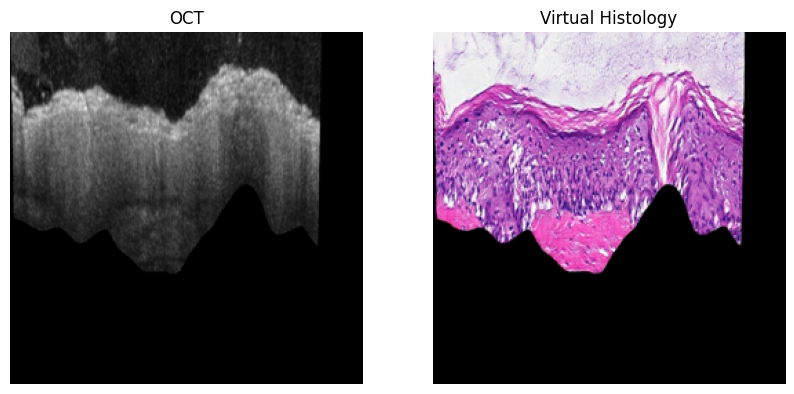

In [7]:
# Load the virtual histology image
histology_image = cv2.imread(f"{base_folder}/results/pix2pix/test_latest/images/im1_fake_B.png")
histology_image = cv2.cvtColor(histology_image, cv2.COLOR_BGR2RGB)

# present side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(oct_image_orig)
axes[0].axis("off")
axes[0].set_title("OCT")
axes[1].imshow(histology_image)
axes[1].axis("off")
axes[1].set_title("Virtual Histology")
plt.show()
